In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
import  torch 
import pandas as pd
from evaluation import metric
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# benchmark quantitative results

In [3]:
benchmark_folder = '/home/ysheng/Dataset/benchmark_ds/'
gt_folder = join(benchmark_folder, 'shadow_gt')
exp_folder = join(benchmark_folder, 'old_baseline_human')

In [ ]:
def read_img(file):
#     img = plt.imread(file)
#     import pdb; pdb.set_trace()
    img = cv2.imread(file,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    img = img/img.max()
    return img

def to_metric_img(img):
    img = (img[:,:,0] + img[:,:,1] + img[:,:,2])/3.0
    cv2.normalize(img, img, 0.0,1.0,cv2.NORM_MINMAX)
    return img

def one_folder_result(gt_folder, exp_folder, subfolder):
    exp_sub = join(exp_folder, subfolder)
    gt_sub = join(gt_folder, subfolder)
    models = glob.glob(join(exp_sub, '*'))
    result = []    
    for m in tqdm(models):
        files = glob.glob(join(m, 'shadow_*.npy'))
        for file in files:
            gt_file = os.path.splitext(os.path.basename(file))[0]
            
            import pdb; pdb.set_trace()
            gt_file = join(gt_sub, join(os.path.basename(m), gt_file + '.png'))
            
            gt_img = 1.0 - to_metric_img(read_img(gt_file))
            pred_img = to_metric_img(np.load(file))
            
            plt.figure(figsize=(15,10))
            plt.subplot(1,2,1)
            plt.imshow(gt_img, cmap='gray')
            plt.subplot(1,2,2)
            plt.imshow(pred_img, cmap='gray')
            
            rmse, rmse_s, zncc, dssim = metric.rmse(gt_img, pred_img), metric.rmse_s(gt_img, pred_img)[1], metric.ZNCC(gt_img, pred_img), metric.DSSIM(gt_img, pred_img)
            
            result.append([gt_file, file,  rmse, rmse_s, zncc, dssim])
            
            break
        break
            
    return result

result = [['gt_file', 'pred_file', 'RMSE', 'RMSE-s', 'ZNCC', 'DSSIM']]
result = result + one_folder_result(gt_folder,exp_folder,'human')
result = result + one_folder_result(gt_folder,exp_folder,'general')

df = pd.DataFrame(data=result)
display(df)


  0%|          | 0/9 [00:00<?, ?it/s]

> <ipython-input-8-f1253c2353b0>(24)one_folder_result()
-> gt_file = join(gt_sub, join(os.path.basename(m), gt_file + '.png'))


(Pdb)  print(gt_file)


shadow_pitch_19_rot_46_fov_63_mts_23_0


(Pdb)  n


> <ipython-input-8-f1253c2353b0>(26)one_folder_result()
-> gt_img = 1.0 - to_metric_img(read_img(gt_file))


(Pdb)  print(gt_file)


/home/ysheng/Dataset/benchmark_ds/shadow_gt/human/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/shadow_pitch_19_rot_46_fov_63_mts_23_0.png


# Sample results

In [9]:
def show(img):
    plt.figure(figsize=(15,10))
    plt.imshow(img)
    plt.show()
    

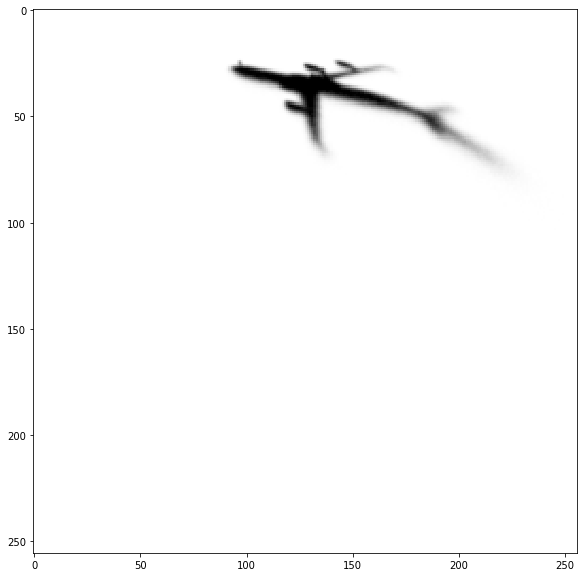

In [10]:
test_gt = '/home/ysheng/Dataset/benchmark_ds/shadow_gt/general/airplane_0685/shadow_pitch_15_rot_-28_fov_92_mts_1_0.png'
img = plt.imread(test_gt)
show(img)

In [11]:
def get_mask_ibl(path, general=True):
    """ Given gt path, return mask and ibl map
    """
    mask_root = '/home/ysheng/Dataset/benchmark_ds/mask'
    ibl_root = '/home/ysheng/Dataset/benchmark_ds/lights'
    if general:
        mask_root = join(mask_root, 'general')
    else:
        mask_root = join(mask_root, 'human')

    model_name = os.path.basename(os.path.dirname(path))
    basename = os.path.basename(path)
    pitch_rot = basename[basename.find('pitch'):basename.find('_mts')]
    ibl = basename[basename.find('mts')+len('mts_'):basename.find('.png')]
    
    mask_path = join(mask_root, join(model_name, pitch_rot + '_mask.png'))
    ibl_path = join(ibl_root, ibl + '.png')
    
    return mask_path, ibl_path

mask, ibl = get_mask_ibl(test_gt)

In [12]:
from ssn.ssn_touch import SSN_Touch
from ssn.ssn_dataset import ToTensor

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SSN_Touch()
model.to(device)
checkpoint = torch.load('weights/new_arch_baseline.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

(256, 256, 1)


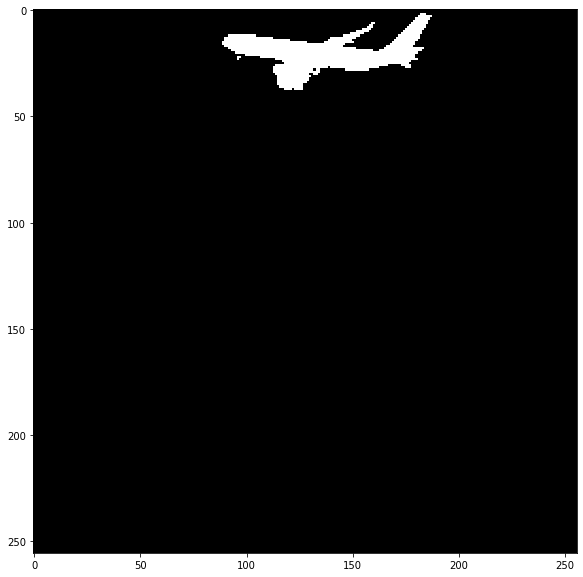

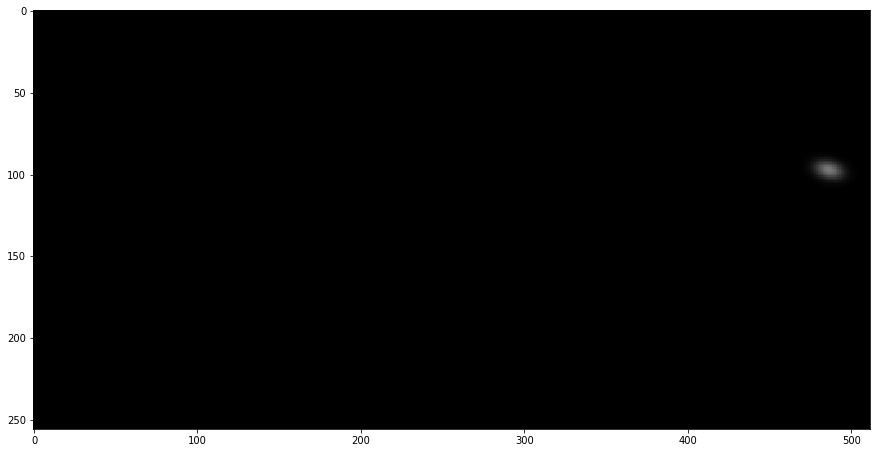

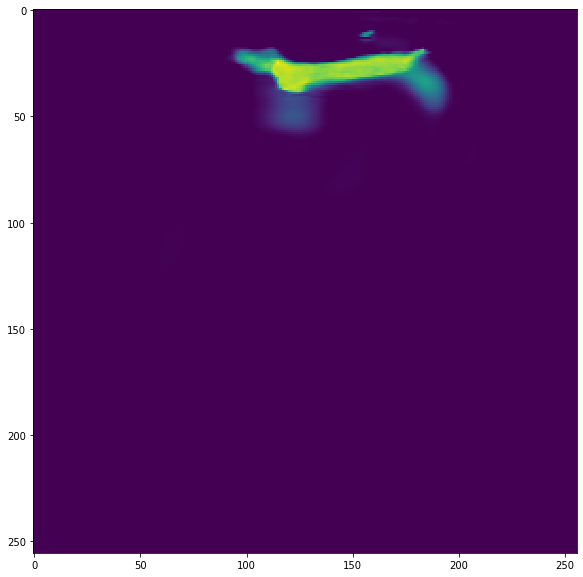

In [18]:
def to_net_ibl(ibl_file):
    """ input:  32 x 16
        output: 32 x 8
    """
    def normalize_energy(ibl, energy=30.0):
        sum_ibl = np.sum(ibl)
        if sum_ibl < 1e-3:
            return ibl * 0.0
        return ibl * energy / sum_ibl

    ibl = plt.imread(ibl_file)
    if np.uint8 == ibl.dtype:
        ibl = ibl / 255.0
    
    ibl = ibl[:128,:,:1]
    ibl = cv2.resize(ibl, (32,16))
#     ibl = cv2.flip(ibl, 0)
    return normalize_energy(ibl)

tensor_convert = ToTensor()
def to_tensor(mask_np, ibl_np):
    assert len(mask_np.shape) == 2
    
    mask = mask_np[:,:,np.newaxis]
    ibl_np = ibl_np[:,:,np.newaxis]
    mask = tensor_convert(mask)
    ibl = tensor_convert(ibl_np)
    return mask.unsqueeze(0), ibl.unsqueeze(0)

def ssn_touch_pred(model, mask, ibl):
    ibl_img = to_net_ibl(ibl)
    mask_img = plt.imread(mask)
    if mask_img.dtype == np.uint8:
        mask_img = mask_img/255.0
    
    mask_img = (mask_img[:,:,0] + mask_img[:,:,1] + mask_img[:,:,2])/3.0
    mask, ibl = to_tensor(mask_img, ibl_img)
    mask, ibl = mask.to(device), ibl.to(device)
    touch = torch.zeros((1,1,256,256)).to(device)
    I_s = torch.cat((mask, touch), 1)
    
    I_s = I_s.to(device)
    shadow, touch_pred = model(I_s, ibl)
    
    I_s = torch.cat((mask, touch_pred), 1)
    I_s = I_s.to(device)
    shadow, touch_pred = model(I_s, ibl)
    
    return shadow[0].detach().cpu().numpy().transpose((1,2,0))

img = ssn_touch_pred(model, mask, ibl)
print(img.shape)
show(plt.imread(mask))
show(plt.imread(ibl))
show(img.squeeze())